In [1]:
import numpy as np
import matplotlib.pyplot as plt


## market parameters
mu     = 0.05
sigmay = 0.1
sigmaz = 0.05
T      = 1
tau0   = 0.2
taul   = 0.8
gamma  = 0.1
x0     = 0
y0     = 0
S0     = 10
ratio = sigmay/sigmaz
phi0   = (mu+y0)/(gamma*(sigmaz**2))
cbar   = ratio*np.tanh(ratio*T)/(4*gamma)
Tsteps = 100
N_fine = 100000
dt     = T/Tsteps
d_fine = T/N_fine
time   = np.linspace(0, T, Tsteps+1)

In [2]:
##
def ell(t):
  return ratio*np.sinh(ratio*(T-2*t))/(4*gamma*np.cosh(ratio*T))

## indifferent subscription rate
def chat(t):
  return cbar - ell(t)

## interesting example of c(t)
def c(t, t0=tau0, tl = taul):
  # ct = 0
  ct = np.where(t<t0, chat(t0), chat(t))
  ct = np.where(t>tl, chat(tl), ct)
  return ct

In [3]:
## simulation of market sample path
def market_path(n_samples=1):
  dBy = np.random.standard_normal([n_samples, Tsteps])*np.sqrt(dt)
  dBz = np.random.standard_normal([n_samples, Tsteps])*np.sqrt(dt)
  Y   = y0*np.ones([n_samples, Tsteps+1])
  S   = S0*np.ones([n_samples, Tsteps+1])
  for t in range(Tsteps):
    Y[:,t+1] = Y[:,t] + sigmay*dBy[:,t]
    S[:,t+1] = S[:,t]+(mu+Y[:,t])*dt + sigmaz*dBz[:,t]
  return Y, S

## information filtering
def filter_Y(S):
  Yhat1 = y0*np.ones_like(S)
  Yhat1[:,1:] = y0+ratio*np.tanh(ratio*time[1:])*(S[:,1:]-S0-mu*time[1:]) \
               - dt*(ratio**2)*\
               np.cumsum(np.cosh(ratio*time[1:])*(S[:,1:]-S0-mu*time[1:]),axis=1)\
               /np.cosh(ratio*time[1:])

  dS   = S[:,1:] - S[:,:-1]
  Yhat = y0*np.ones_like(S)
  Yhat[:,1:] = y0 + ratio*np.cumsum(np.sinh(ratio*time[1:])*(dS-mu*dt))/np.cosh(ratio*time[1:])

  return Yhat, Yhat1#, Yhat2

## agents with information on Y
def informed(S, Y, X_ini, cost=chat):
  _, N_T    = Y.shape
  t_start   = T-dt*(N_T-1)
  time_I    = np.linspace(t_start, T, N_T)
  phi_I     = (mu+Y)/(gamma*(sigmaz**2))
  dS        = S[:,1:] - S[:,:-1]
  time_fine = np.linspace(t_start, T, N_fine)
  dt_fine   = (T-t_start)/N_fine
  Cost      = np.sum(cost(time_fine)*dt_fine)
  X_I       = np.ones_like(S)
  X_I[:,0]  = X_ini-Cost
  X_I[:,1:] = X_ini.reshape([-1,1])-Cost+np.cumsum(phi_I[:,:-1]*dS[:,:], axis=1)
  V_I       = -np.exp(-gamma*X_I-((mu+Y)**2)*np.tanh(ratio*(T-time_I))/(2*sigmay*sigmaz))\
              /np.sqrt(np.cosh(ratio*(T-time_I)))
  return phi_I, V_I, X_I

## agents without information on Y
def uninformed(S,Y,X_ini):
  _, N_T     = Y.shape
  t_end      = dt*(N_T-1)
  time_UI    = np.linspace(0,t_end,N_T)
  dS         = S[:,1:] - S[:,:-1]
  phi_UI     = (mu+Y)*np.cosh(ratio*(T-time_UI))*np.cosh(ratio*time_UI)\
                 /(gamma*(sigmaz**2)*np.cosh(ratio*T))
  X_UI       = X_ini*np.ones_like(S)
  X_UI[:,1:] = X_ini+np.cumsum(phi_UI[:,:-1]*dS[:,:], axis=1)
  V_UI       = -np.sqrt(np.cosh(ratio*time_UI)/np.cosh(ratio*T))\
               *np.exp(-gamma*X_UI-((mu+Y)**2)*np.cosh(ratio*time_UI)\
                       *np.sinh(ratio*(T-time_UI))/(2*sigmay*sigmaz*np.cosh(ratio*T))\
                       +cbar*gamma*(T-time_UI) \
                       +np.sinh(ratio*(T-time_UI))*np.sinh(ratio*(time_UI))/(4*np.cosh(ratio*T)))
  # *np.exp(-gamma*X_UI-((mu+Y)**2)*np.cosh(ratio*time_UI)*np.sinh(ratio(T-time))/(2*sigmay*sigmaz*np.cosh(ratio*T))+cbar*gamma*(T-time_UI) + np.sinh(ratio*(T-time_UI))*np.sinh(ratio*(time_UI))/(4*np.cosh(ratio*T)))
  return phi_UI, V_UI, X_UI

[0.76200369] [-4.35287577]
[-2.65653944] [-9.64737949]


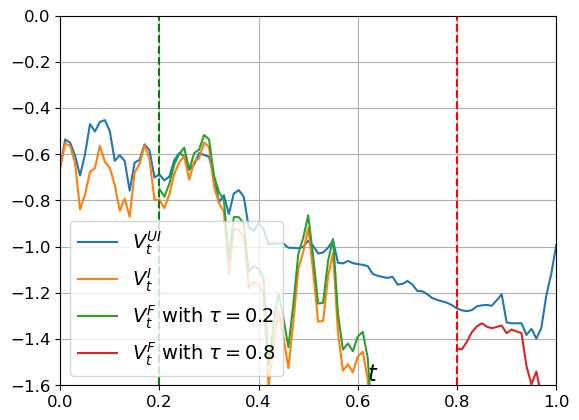

-0.75048831001234
-0.7977219048916884
-2.4712345195833008
-1.4432205113073477
-0.6876798962223609
-1.2674499843561609


In [26]:
np.random.seed(100257)
Y,S  = market_path()
X    = x0*np.ones_like(Y[:,0])
Yhat,Yhat1 = filter_Y(S)
phi_I, V_I, X_I = informed(S,Y, X)
phi_UI, V_UI, X_UI = uninformed(S,Yhat,X)
t0 = int(tau0/dt)
tl = int(taul/dt)
phi0, V0, X_0 = informed(S[:,t0:], Y[:,t0:], X_UI[:,t0])
print(X_UI[:,t0], X_I[:,t0])
print(X_UI[:,tl], X_I[:,tl])

phil, Vl, X_l = informed(S[:,tl:], Y[:,tl:], X_UI[:,tl])

fig, ax = plt.subplots()
ax.plot(time, V_UI[0,:], label=r'$V^{UI}_t$')
# plt.plot(time, np.exp(-((mu+Y[0,:])**2)*np.tanh(ratio*(T-time))/(2*sigmay*sigmaz)))
ax.plot(time, V_I[0,:], label=r'$V^{I}_t$')
ax.plot(time[t0:], V0[0,:], label=r'$V^F_t$ with $\tau=0.2$')
ax.plot(time[tl:], Vl[0,:], label=r'$V^F_t$ with $\tau=0.8$')
ax.axvline(tau0, color='g', linestyle = 'dashed')
ax.axvline(taul, color='r', linestyle = 'dashed')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-1.6,-0.0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlabel(r'$t$', fontsize=16)
ax.xaxis.set_label_coords(.63, 0.06)
ax.legend(loc='lower left', fontsize=14)
ax.grid()
plt.savefig('value.pdf', format='pdf', bbox_inches='tight')
plt.show()
print(np.sum(V0[:,0]))
print(np.sum(V_I[:,t0]))
print(np.sum(V_I[:,tl]))
print(np.sum(Vl[:,0]))
print(np.sum(V_UI[:,t0]))
print(np.sum(V_UI[:,tl]))

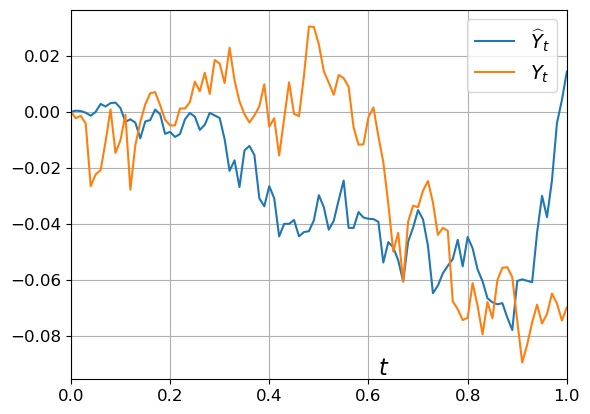

In [32]:
# Yhat = filter_Y(S)
fig, ax = plt.subplots()
ax.plot(time, Yhat[0,:],label=r'$\widehat{Y}_t$')
# plt.plot(time, Yhat1[0,:],label=r'$\widehat{Y}_t$')
ax.plot(time, Y[0,:],label=r'$Y_t$')
ax.set_xlim(0.0, 1.0)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlabel(r'$t$', fontsize=16)
ax.xaxis.set_label_coords(.63, 0.06)
ax.grid()
plt.savefig('Y.pdf', format='pdf', bbox_inches='tight')
plt.show()

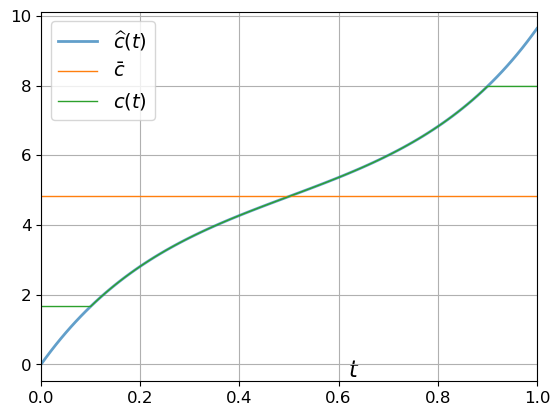

In [33]:
## Plot of cbar and chat
fig, ax  = plt.subplots()

ax.plot(time, chat(time), label=r'$\widehat{c}(t)$', linewidth=2,alpha=0.7)
ax.plot(time, cbar*np.ones(np.size(time)), label=r'$\bar{c}$', linewidth=1)
ax.plot(time, c(time, 0.1,0.9), label=r'${c}(t)$', linewidth=1)
ax.set_xlim(0.0, 1.0)
# plt.ylim(0.0, 4.0)
ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_xlabel(r'$t$', fontsize=16)
ax.xaxis.set_label_coords(.63, 0.06)
ax.grid()
plt.savefig('rate_c.pdf', format='pdf', bbox_inches='tight')
plt.show()

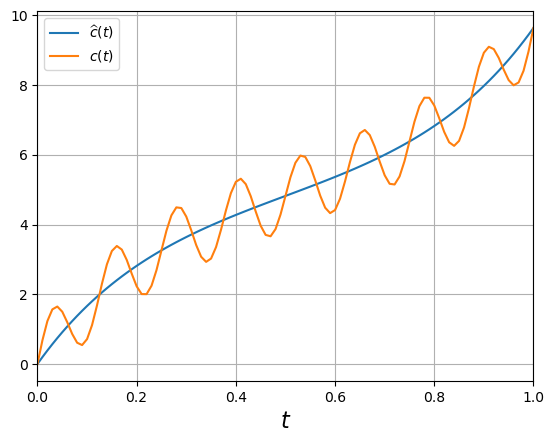

In [25]:
## Plot of a weird prescribed subscription rate, where there needs more conditions 
plt.plot(time, chat(time), label=r'$\widehat{c}(t)$')
plt.plot(time, chat(time)+np.sin(time*(16*np.pi)), label=r'$c(t)$')
# plt.plot(time, cbar*np.ones(np.size(time)), label=r'$\bar{c}$')
# plt.plot(time, c(time, 0.1,0.9), label=r'${c}(t)$')
plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 4.0)
plt.legend()
plt.xlabel(r'$t$', fontsize=16)
plt.grid()
plt.savefig('crazy_rate_c.pdf', format='pdf', bbox_inches='tight')
plt.show()

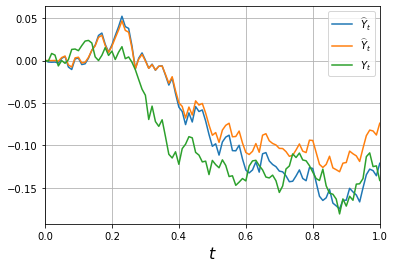

In [228]:
### Sanity check 
## market parameters
mu     = 0.05
sigmay = 0.1
sigmaz = 0.01
T      = 1
tau0   = 0.2
taul   = 0.8
gamma  = 0.1
x0     = 0
y0     = 0
S0     = 10
ratio = sigmay/sigmaz
phi0   = (mu+y0)/(gamma*(sigmaz**2))
cbar   = ratio*np.tanh(ratio*T)/(4*gamma)
Tsteps = 100
N_fine = 100000
dt     = T/Tsteps
d_fine = T/N_fine
time   = np.linspace(0, T, Tsteps+1)

np.random.seed(1002577)
Y,S  = market_path()
Yhat,Yhat1 = filter_Y(S)
plt.plot(time, Yhat[0,:],label=r'$\widehat{Y}_t$')
plt.plot(time, Yhat1[0,:],label=r'$\widehat{Y}_t$')
plt.plot(time, Y[0,:],label=r'$Y_t$')
plt.xlim(0.0, 1.0)
plt.legend()
plt.xlabel(r'$t$', fontsize=16)
plt.grid()
plt.show()